In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import gridspec

In [2]:
ds=pd.read_csv('aug_train.csv')
ds.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
ds.dtypes

enrollee_id                 int64
city                       object
city_development_index    float64
gender                     object
relevent_experience        object
enrolled_university        object
education_level            object
major_discipline           object
experience                 object
company_size               object
company_type               object
last_new_job               object
training_hours              int64
target                    float64
dtype: object

In [4]:
gen_targ=pd.crosstab(ds.gender, ds.target,margins=True)
rev_exp_targ=pd.crosstab(ds.relevent_experience, ds.target,margins=True)
edu_lvl_targ=pd.crosstab(ds.education_level, ds.target,margins=True)
las_job_targ=pd.crosstab(ds.last_new_job, ds.target,margins=True)

<AxesSubplot:xlabel='last_new_job', ylabel='value'>

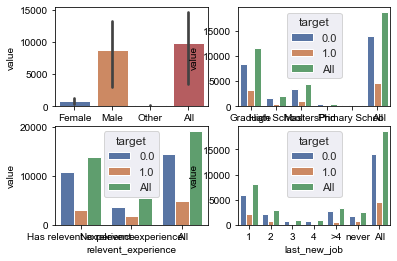

In [5]:

stacked1 = gen_targ.stack().reset_index().rename(columns={0:'value'})
stacked2 = rev_exp_targ.stack().reset_index().rename(columns={0:'value'})
stacked3 = edu_lvl_targ.stack().reset_index().rename(columns={0:'value'})
stacked4 = las_job_targ.stack().reset_index().rename(columns={0:'value'})


fig, axs = plt.subplots(nrows=2,ncols=2)
sns.set(rc={'figure.figsize':(20,12)})
sns.barplot(x=stacked1.gender, y=stacked1.value,ax=axs[0,0])
sns.barplot(x=stacked2.relevent_experience, y=stacked2.value, hue=stacked2.target,ax=axs[1,0])
sns.barplot(x=stacked3.education_level, y=stacked3.value, hue=stacked3.target,ax=axs[0,1])
sns.barplot(x=stacked4.last_new_job, y=stacked4.value, hue=stacked4.target,ax=axs[1,1])

In [6]:
ds.training_hours.describe()

count    19158.000000
mean        65.366896
std         60.058462
min          1.000000
25%         23.000000
50%         47.000000
75%         88.000000
max        336.000000
Name: training_hours, dtype: float64

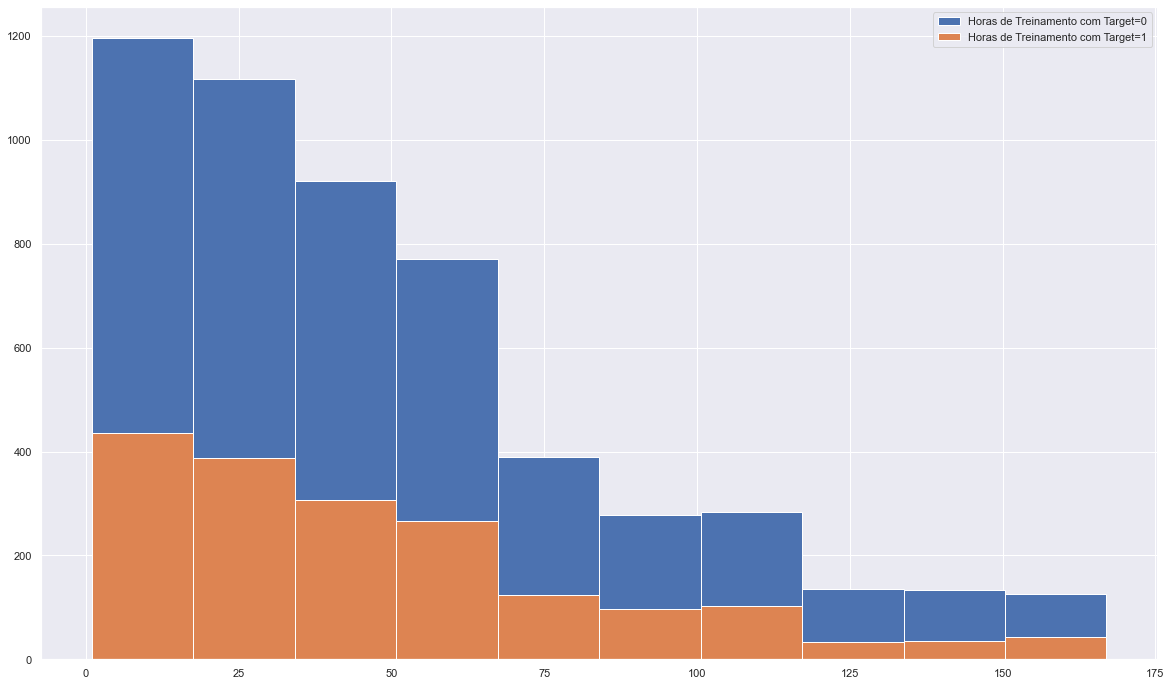

In [7]:
from matplotlib import pyplot

pyplot.hist(ds[(ds.training_hours) & (ds.target==0)].training_hours,label='Horas de Treinamento com Target=0')
pyplot.hist(ds[(ds.training_hours) & (ds.target==1)].training_hours,label='Horas de Treinamento com Target=1')
pyplot.legend(loc='upper right')
pyplot.show()

(array([1196., 1117.,  920.,  770.,  390.,  278.,  284.,  136.,  133.,
         126.]),
 array([  1. ,  17.6,  34.2,  50.8,  67.4,  84. , 100.6, 117.2, 133.8,
        150.4, 167. ]),
 <BarContainer object of 10 artists>)

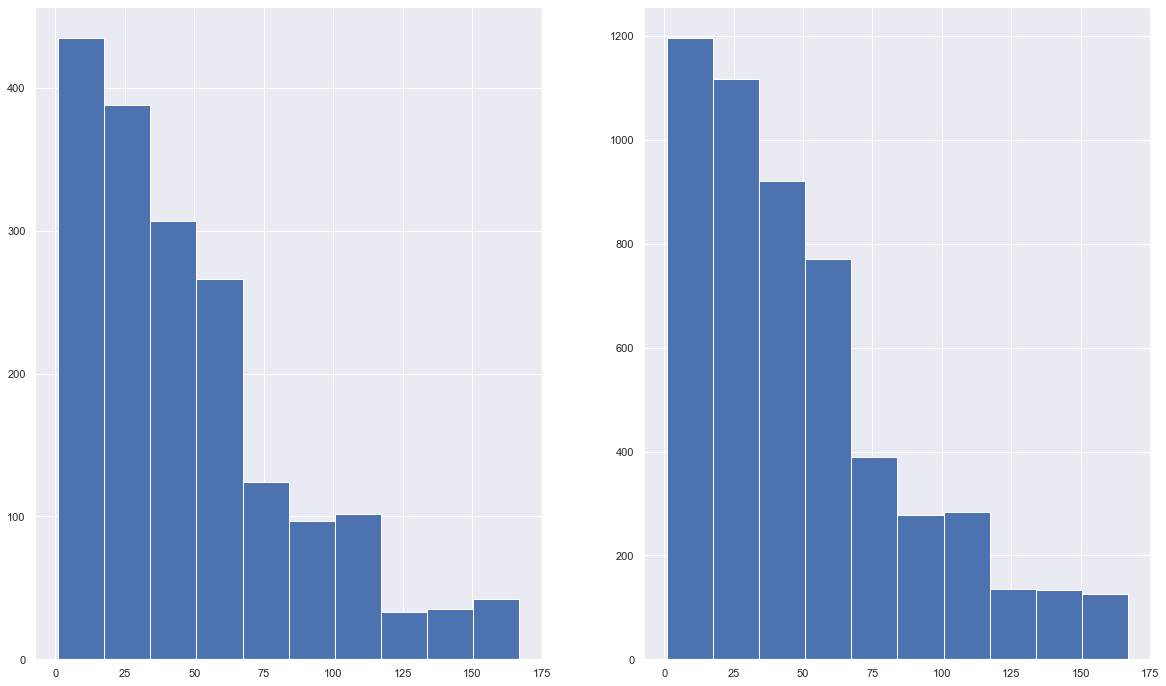

In [8]:
from matplotlib import gridspec

fig=plt.figure(figsize=(20,12))
specs=gridspec.GridSpec(ncols=2, nrows=1,figure=fig)


ax1=fig.add_subplot(specs[0,0]) #first row
ax2=fig.add_subplot(specs[0,1]) #second row first column

# First graph
ax1.hist(ds[(ds.training_hours) & (ds.target==1)].training_hours)

ax2.hist(ds[(ds.training_hours) & (ds.target==0)].training_hours)